In [2]:
import os
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
from seisbench.util import worker_seeding
from seisbench.models import SeisBenchModel 

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [3]:
data = sbd.TXED(cache="full",sampling_rate=100) #Esta accion es recomendable hacerla en terminal pues tarda mucho
                                #cambiar a "full" una vez que este completo el codigo
#data = sbd.DummyDataset(sampling_rate=50)  #sampling_rate=100
data.preload_waveforms(pbar=True) #importante, pbar==progressbar
print(data)

2024-09-01 14:17:40,316 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
Preloading waveforms:   0%|          | 0/1046 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 1046/1046 [00:06<00:00, 150.97it/s]

TXED - 1046 traces


In [4]:
train, dev, test = data.train_dev_test()

In [5]:
print(len(train))
print(len(test))
print(len(dev))

631
292
123


In [6]:
train_generator = sbg.GenericGenerator(train)
test_generator = sbg.GenericGenerator(test)
dev_generator = sbg.GenericGenerator(dev)

In [7]:
train_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
test_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
dev_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

In [8]:
@train_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

@test_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

@dev_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

print(dev_generator[1])

{'X': array([[-0.21555895, -0.2407768 , -0.23092718, ...,  0.08652241,
         0.11116604,  0.11743152],
       [ 0.02879117, -0.01321497, -0.03130574, ...,  0.01342007,
         0.01596949,  0.00648704],
       [ 0.04727374,  0.07649925,  0.07896791, ...,  0.00982833,
         0.01083625,  0.01271498]]), 'y': 6}


In [9]:
batch_size = 128
num_workers = 0  # The number of threads used for loading data

#worker_init_fn es principalmente usado cuando se trabaja en parallelo para que todos los "workers" tengan mismas condiciones 
train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

### Model

In [10]:
class ConvNetQuake(SeisBenchModel):
    def __init__(self, inputs, config, checkpoint_dir, is_training=False):
        super(ConvNetQuake, self).__init__(citation=config.citation)
        self.is_training = is_training
        self.config = config
        self.checkpoint_dir = checkpoint_dir
        
        # Parámetros
        c = 32  # número de canales por capa conv
        ksize = 3  # tamaño del kernel de la convolución
        depth = 8  # profundidad de la red
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Capas convolucionales
        layers = []
        in_channels = inputs.shape[1]
        for i in range(depth):
            layers.append(nn.Conv1d(in_channels, c, kernel_size=ksize, stride=2, padding=1))
            layers.append(nn.ReLU())
            in_channels = c
        self.conv_layers = nn.Sequential(*layers)

        # Dummy input para calcular el tamaño de la salida
        dummy_input = torch.zeros(1, inputs.shape[1], inputs.shape[2]).to(self.device)
        output_size = self.conv_layers(dummy_input).numel()

        # Capa completamente conectada
        self.fc = nn.Linear(output_size, config.n_clusters)
        
        # Inicialización
        self.to(self.device)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Aplanar
        logits = self.fc(x)
        class_prob = F.softmax(logits, dim=1)
        class_prediction = torch.argmax(class_prob, dim=1)
        return logits, class_prob, class_prediction

    def loss_function(self, logits, targets):
        loss = F.cross_entropy(logits, targets)
        reg_loss = self.config.regularization * sum(param.norm(2) for param in self.parameters())
        return loss + reg_loss

    def accuracy(self, logits, targets):
        predictions = torch.argmax(logits, dim=1)
        correct = (predictions == targets).float()
        accuracy = correct.sum() / len(correct)
        return accuracy

    def validation_metrics(self, logits, targets):
        loss = self.loss_function(logits, targets)
        det_accuracy = self.accuracy(logits, targets)
        loc_accuracy = det_accuracy  # Puede diferir si hay otras métricas de localización
        return {"loss": loss.item(), "detection_accuracy": det_accuracy.item(), "localization_accuracy": loc_accuracy.item()}

    def validation_metrics_message(self, metrics):
        return 'loss = {:.5f} | det. acc. = {:.1f}% | loc. acc. = {:.1f}%'.format(
            metrics['loss'], metrics['detection_accuracy']*100, metrics['localization_accuracy']*100)

    def _setup_optimizer(self, learning_rate):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def _summary_step(self, step_data):
        step = step_data['step']
        loss = step_data['loss']
        det_accuracy = step_data['detection_accuracy']
        loc_accuracy = step_data['localization_accuracy']
        duration = step_data['duration']
        avg_duration = 1000*duration/step

        if self.is_training:
            return f'Step {step} | {duration:.0f}s ({avg_duration:.0f}ms) | loss = {loss:.4f} | det. acc. = {100*det_accuracy:.1f}% | loc. acc. = {100*loc_accuracy:.1f}%'
        else:
            return f'Step {step} | {duration:.0f}s ({avg_duration:.0f}ms) | accuracy = {100*det_accuracy:.1f}% | accuracy = {100*loc_accuracy:.1f}%'

    def train_step(self, inputs, targets):
        self.train()
        logits, _, _ = self(inputs)
        loss = self.loss_function(logits, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def evaluate(self, inputs, targets):
        self.eval()
        with torch.no_grad():
            logits, _, _ = self(inputs)
            metrics = self.validation_metrics(logits, targets)
        return metrics

In [47]:
import torch.nn as nn
class modelo_joel(SeisBenchModel):  #               from .base import WaveformModel??????????
    def __init__(self, citation=None, num_classes=10, regularization=0.01, input_length=3001, sampling_rate=100):
        self.regularization = regularization

        super().__init__()
        # Parámetros
        c = 32  # número de canales por capa conv
        ksize = 3  # tamaño del kernel de la convolución
        depth = 8  # profundidad de la red
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Capas convolucionales
        layers = []
        in_channels = 3
        for i in range(depth):
            layers.append(nn.Conv1d(in_channels, c, kernel_size=ksize, stride=2, padding=1))
            layers.append(nn.ReLU())
            in_channels = c
            self.conv_layers = nn.Sequential(*layers)

        # Dummy input para calcular el tamaño de la salida
        dummy_input = torch.zeros(1, 3, input_length).to(self.device)
        output_size = self.conv_layers(dummy_input).numel()

        # Capa completamente conectada
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_layers(x)
        print(f"Shape after conv layers: {x.shape}")
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        return logits
    
    def loss_func(self,logits,targets):
        loss = nn.CrossEntropyLoss()(logits, targets)
        reg_loss = self.regularization * sum(param.norm(2) for param in self.parameters())
        return loss + reg_loss

    def accuracy(self, logits,targets):
        # hay dos accuracies en el modelo original, se enfocara en "location accuracy"
        predictions = torch.argmax(logits, dim=1)
        correct = (predictions == targets).float()
        accuracy = correct.sum() / len(correct)
        return accuracy


In [12]:
learning_rate = 0.001

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = modelo_joel(input_length=6001,num_classes=8)
model.to(device)

modelo_joel(
  (conv_layers): Sequential(
    (0): Conv1d(3, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU()
    (6): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): ReLU()
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): ReLU()
    (10): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (11): ReLU()
    (12): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): ReLU()
    (14): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (15): ReLU()
  )
  (fc): Linear(in_features=768, out_features=8, bias=True)
)

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
for batch_id, batch in enumerate(train_loader):
    print(len(batch['y']))


128
128
128
128
119


In [68]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epoch = 25
for i in range(epoch):
    running_loss = 0
    running_acc = 0
    model.train()  # Set the model to training mode
    for batch_id, batch in enumerate(train_loader):
    ################## Train 
        # Reset the gradients to zero
        optimizer.zero_grad()

        # Forward pass
        output = model(batch['X'].float())

        # Calculate the loss
        loss = model.loss_func(output,batch['y'])
        acc = model.accuracy(output,batch['y'])

        # Backpropagation
        loss.backward()

        # Update the model's weights
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()
    print("Epoch {} - Training loss: {}".format(i + 1, running_loss / len(train_loader)))
    train_loss.append(running_loss / len(train_loader))

    train_acc.append(running_acc/len(train_loader))

    ################## Test
    model.eval()
    running_loss2 = 0
    running_acc2 = 0
    for batch_id, batch in enumerate(test_loader):
        output = model(batch['X'].float())
        loss2 = model.loss_func(output,batch['y'])
        acc2 = model.accuracy(output,batch['y'])
        running_loss2 += loss.item()
        running_acc2 += acc2.item()

    test_loss.append(running_loss2 / len(test_loader))

    test_acc.append(running_acc2/len(test_loader))



Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([119, 3, 6000])
Shape after conv layers: torch.Size([119, 32, 24])
Epoch 1 - Training loss: 2.3610864162445067
Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([36, 3, 6000])
Shape after conv layers: torch.Size([36, 32, 24])
Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([128, 3, 6000])
Shape after conv layers: torch.Size([128, 32, 24])
Input shape: torch.Size([128, 3, 6000])
Shape af

In [69]:
len(train_loader)

5

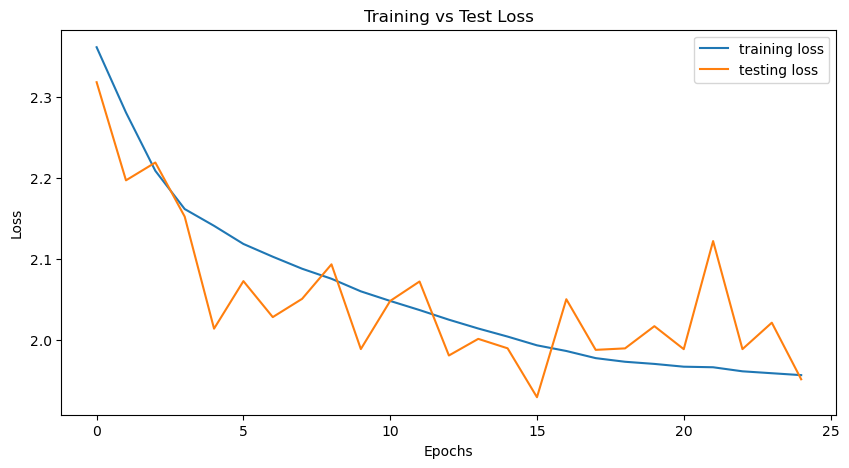

In [70]:
plt.figure(figsize=(10,5))
plt.plot(train_loss,label='training loss')
plt.plot(test_loss,label='testing loss')
plt.title("Training vs Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0, 0.5, 'Accuracy')

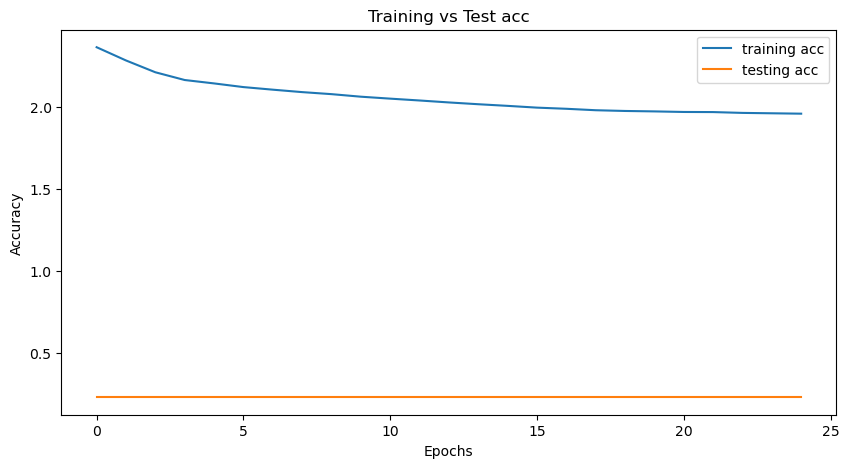

In [71]:
plt.figure(figsize=(10,5))
plt.plot(train_loss,label='training acc')
plt.plot(test_acc,label='testing acc')
plt.title("Training vs Test acc")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Prueba

3


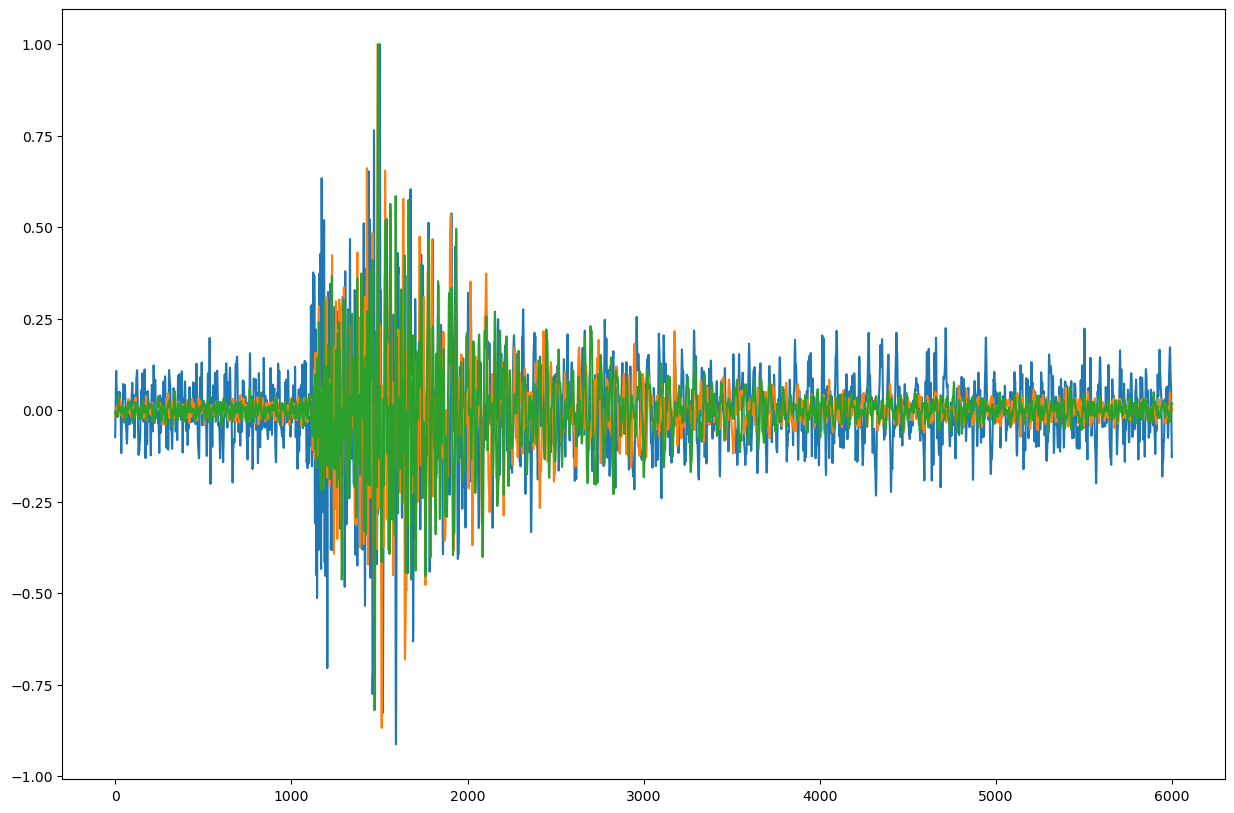

In [75]:
sample = dev_generator[np.random.randint(len(dev_generator))]
fig = plt.figure(figsize=(15, 10))
#axs = fig.plot(1, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
plt.plot(sample["X"].T)
print(sample["y"])

In [76]:
model.eval()
with torch.no_grad():
    pred = model(torch.tensor(sample['X']).float().unsqueeze(0))  # unsqueeze(0) to add a fake batch dimension
    prob = torch.softmax(pred,dim=1)
    print(prob)

Input shape: torch.Size([1, 3, 6000])
Shape after conv layers: torch.Size([1, 32, 24])
tensor([[0.2295, 0.1397, 0.0321, 0.1893, 0.1973, 0.0594, 0.0982, 0.0545]])


In [74]:
torch.argmax(prob,dim=1)

tensor([0])